## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest

In [2]:
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [3]:
#1) The kernel after parameter optimization and fitting to the observed data. (10 pts)
X_df = Data1.iloc[:,0:2]
y_df = np.log(Data1['AvgDailyTrafficCount']) - np.log(Data1['AvgDailyTrafficCount']).mean()
Data1['normalized'] = y_df

In [4]:
# parameters of RBF kernel: length_scale, (length_scale_range_min, length_scale_range_max)
kernel = 1.* RBF(length_scale=1., length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10))

#fit the data and print out the result
gpc_rbf = GaussianProcessRegressor(kernel=kernel, random_state=1).fit(X_df, y_df)


print(gpc_rbf.kernel_)

0.662**2 * RBF(length_scale=0.0355) + WhiteKernel(noise_level=0.567)


In [5]:
#2) The log marginal likelihood of the training data. (5 pts
print (gpc_rbf.log_marginal_likelihood_value_)

-1365.946691913936


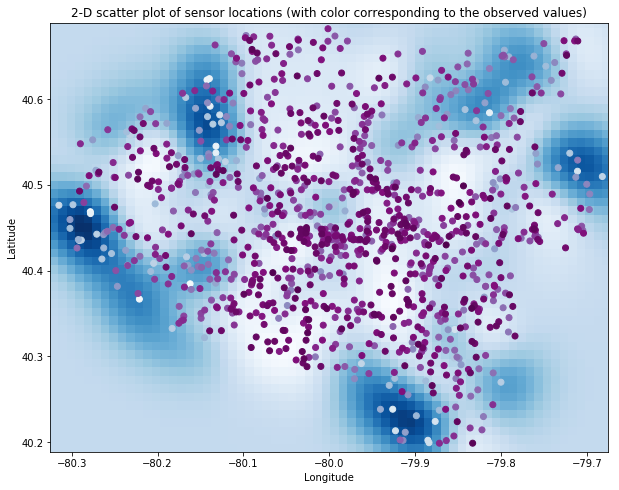

In [6]:
#3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude 
#(with color corresponding to the model's predictions) and overlay a 2-D scatter plot 
#of sensor locations (with color corresponding to the observed values). (10 pts)
h = 0.01
X = np.array(X_df)
y = np.array(y_df)

x_min, x_max = X[:, 0].min() - 0.01, X[:, 0].max() + 0.01
y_min, y_max = X[:, 1].min() - 0.01, X[:, 1].max() + 0.01

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = gpc_rbf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(len(np.arange(y_min, y_max, h)),len(np.arange(x_min, x_max, h)))


plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

#plot the mesh
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), cmap=plt.cm.Blues_r, origin="lower")

#plot the scatter
plt.scatter(X[:,0], X[:,1], c=y, cmap='BuPu')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-D scatter plot of sensor locations (with color corresponding to the observed values)")
plt.show()

Figure 1.  This is a figure that shows model prediction of sensor location.

**4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)**

In [7]:
Data1['Predicted'] = gpc_rbf.predict(Data1[['Longitude', 'Latitude']])
Data1['Z_score'] = (Data1['normalized'] - Data1['Predicted'].mean())/Data1['Predicted'].std()
outlier = Data1[abs((Data1['normalized'] - Data1['Predicted'].mean())/Data1['Predicted'].std()) > 2.0]

pct = 100*float(len(outlier)) / float(len(Data1))
print ("percentage of sensors have average traffice counts more than two standard deviations higher or lower than the model prediction is:")
print (pct)

percentage of sensors have average traffice counts more than two standard deviations higher or lower than the model prediction is:
13.452914798206278


**5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)**

In [8]:
above = Data1[Data1['Z_score'] > 2.0]
below = Data1[Data1['Z_score'] < -2.0]
between = Data1[abs(Data1['Z_score']) <= 2.0]

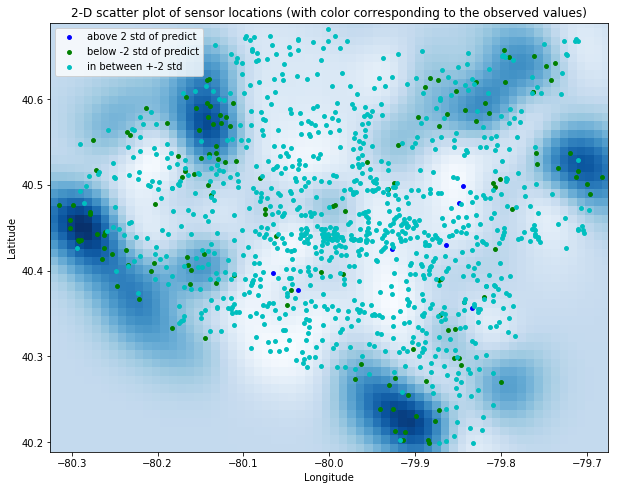

In [9]:
h = 0.01
X = np.array(X_df)
y = np.array(y_df)

x_min, x_max = X[:, 0].min() - 0.01, X[:, 0].max() + 0.01
y_min, y_max = X[:, 1].min() - 0.01, X[:, 1].max() + 0.01

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = gpc_rbf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(len(np.arange(y_min, y_max, h)),len(np.arange(x_min, x_max, h)))


plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

#plot the mesh
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), cmap=plt.cm.Blues_r, origin="lower")

#plot the scatter
plt.scatter(above['Longitude'], above['Latitude'], c='b', label="above 2 std of predict", s=15)
plt.scatter(below['Longitude'], below['Latitude'], c='g', label="below -2 std of predict", s=15)
plt.scatter(between['Longitude'], between['Latitude'], c='c', label="in between +-2 std", s=15)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.legend()
plt.title("2-D scatter plot of sensor locations (with color corresponding to the observed values)")
plt.show()

Figure2.  This is a figure that shows model prediction of sensor location. Three colors corresponding to observed values

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


#### solution:
**(1, 0): Anomaly; Cluster A is a dense cluster cluster contains 100 points with a small std.  This point is 10 std from center(0,0) which is a anomaly.**
  
**(35,2): Not anomaly; The cluster is less dense than cluster A (though it has 150 points )since it has a much larger std. In this case, the point(35,2) is still within 1 std from center which cannot be thought as anomaly.**

**(15,19): Anomaly: Cluster C has only 2 points. In this case, both the points in the cluster and this new point should be considered as anomaly.**

**(10,11): Not anomaly: the point is 1 std away from center. The cluster has 200 points with std=1 which a dense enough cluster.**

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [45]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.set_index('County', inplace=True)
Data2 = Data2.replace('?',np.nan)
Data2.dropna(inplace=True, how='any')
Data2.head()

,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
County,,,,,,,,,,,,,,,,,,,,,
"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,15,...,18,4.3,27,13.8,254,76,12.9,14,89,42
"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,15,...,20,4.5,28,12.0,221,70,13.1,15,84,37
"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,12,...,38,5.3,54,8.1,147,64,12.6,18,84,35
"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,14,...,27,4.3,32,9.8,236,75,12.9,13,84,46
"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,14,...,24,4.1,28,8.5,219,89,12.7,12,85,59


#### Part 1: Learn a Bayesian network structure using only the six features ["'% Smokers'","'% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'% Children in Poverty'","'Average Daily PM2.5'"]. Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4.
(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts)

In [46]:
Data2_selected = Data2[["'\% Smokers'","'\% Obese'",\
       "'Violent Crime Rate'", "'80/20 Income Ratio'", \
       "'\% Children in Poverty'", "'Average Daily PM2.5'"]]
ls = ['smokers', 'obese', 'violent_crime_rate', '80/20_income_ratio', 'children_poverty', 'avg_pm2.5']
Data2_selected.columns = ls
Data2_selected.head()

,smokers,obese,violent_crime_rate,80/20_income_ratio,children_poverty,avg_pm2.5
County,,,,,,
"Autauga, Alabama",19,31,254,4.3,18,12.9
"Baldwin, Alabama",19,27,221,4.5,20,13.1
"Barbour, Alabama",21,41,147,5.3,38,12.6
"Bibb, Alabama",21,40,236,4.3,27,12.9
"Blount, Alabama",19,32,219,4.1,24,12.7


In [47]:
Data2_selected.iloc[:,0:] = np.array(Data2_selected.iloc[:,0:].apply(pd.to_numeric,errors='coerce',downcast='integer'))
Data2_selected.iloc[:,0:] = Data2_selected.iloc[:,0:].apply(pd.cut, bins=5, labels=False)
#Data2_selected.iloc[:,0:] = np.array(Data2_selected.iloc[:,0:].apply(pd.to_numeric,errors='coerce',downcast='integer'))
Data2_selected.dropna(inplace=True, how='any')
Data2_selected.head()

/Users/xiaoguihua/anaconda3/envs/gabriel/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/xiaoguihua/anaconda3/envs/gabriel/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/xiaoguihua/anaconda3/envs/gabriel/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pand

,smokers,obese,violent_crime_rate,80/20_income_ratio,children_poverty,avg_pm2.5
County,,,,,,
"Autauga, Alabama",1,2,0,1,1,3
"Baldwin, Alabama",1,2,0,1,1,3
"Barbour, Alabama",2,4,0,2,3,3
"Bibb, Alabama",2,4,0,1,2,3
"Blount, Alabama",1,2,0,1,2,3


In [48]:
Data2_selected.iloc[:,0:] = Data2_selected.iloc[:,0:].apply(pd.to_numeric,errors='coerce',downcast='integer')

/Users/xiaoguihua/anaconda3/envs/gabriel/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
hc = HillClimbSearch(Data2_selected, scoring_method=BicScore(Data2_selected))
hc_model = hc.estimate()
print(hc_model.edges())

[('smokers', 'obese'), ('smokers', 'avg_pm2.5'), ('80/20_income_ratio', 'children_poverty'), ('children_poverty', 'smokers'), ('children_poverty', 'violent_crime_rate')]


(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

In [50]:
# Log-likelihood of data record x given model
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print (thevariable,theparents,theprob)
        loglike += np.log(theprob)
    return loglike

In [51]:
bayes_model = BayesianModel(hc_model.edges())
bayes_model.fit(Data2_selected, estimator=MaximumLikelihoodEstimator)
Data2_selected['loglikelihood']=Data2_selected.apply(lambda x: LL(x, bayes_model),axis=1)

#print (exmp.sort_values().head(5))

/Users/xiaoguihua/anaconda3/envs/gabriel/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
Data2_selected.head()

,smokers,obese,violent_crime_rate,80/20_income_ratio,children_poverty,avg_pm2.5,loglikelihood
County,,,,,,,
"Autauga, Alabama",1,2,0,1,1,3,-2.961528
"Baldwin, Alabama",1,2,0,1,1,3,-2.961528
"Barbour, Alabama",2,4,0,2,3,3,-7.545400
"Bibb, Alabama",2,4,0,1,2,3,-5.988829
"Blount, Alabama",1,2,0,1,2,3,-3.528275


In [53]:
Data2_selected.sort_values(by= ["loglikelihood"]).head(5).index

Index(['New York, New York', 'San Francisco, California',
       'Roulette, North Dakota', 'Suffolk, Massachusetts',
       'District of Columbia, District of Columbia'],
      dtype='object', name='County')

#### Part 2: Cluster based anomaly detection. Use all numeric features for this part, and do not discretize.
(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

In [54]:
Data2.iloc[:,0:] = Data2.iloc[:,0:].apply(pd.to_numeric,errors='coerce',downcast='integer')
Data2 = Data2.dropna(how='any')
Data_km = Data2
KM=KMeans(n_clusters=3,random_state=522)
scor=KM.fit_predict(Data_km)

In [55]:
res_km=pd.DataFrame(KM.transform(Data_km))
res_km.index = Data_km.index
res_km.columns=list(range(3))
res_km["nearest_dist"] = res_km.min(axis=1)
res_km['cluster'] = res_km.idxmin(axis=1)
res_km.sort_values(by= ["nearest_dist"], ascending=False).head(5)

,0,1,2,nearest_dist,cluster
County,,,,,
"Shannon, South Dakota",2443.781901,1970.324198,2252.115237,1970.324198,1
"St. Louis City, Missouri",2036.497924,1333.684659,1759.881142,1333.684659,1
"Crittenden, Arkansas",1918.080828,1209.851405,1639.710855,1209.851405,1
"Petersburg City, Virginia",1645.051634,1018.437370,1395.557088,1018.437370,1
"Baltimore City, Maryland",1652.289633,919.349842,1367.448537,919.349842,1


(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

In [56]:
Data_gm = Data2
GM=GaussianMixture(n_components=3,random_state=522)
GM.fit(Data_gm)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=522, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [57]:
res_gm=pd.DataFrame()
res_gm["loglikelihood"] = GM.score_samples(Data_gm)
res_gm.index = Data_gm.index
res_gm.sort_values(by= ["loglikelihood"]).head(5)

,loglikelihood
County,
"Shannon, South Dakota",-197.640278
"Apache, Arizona",-133.169600
"New York, New York",-131.535889
"Willacy, Texas",-129.175629
"Roulette, North Dakota",-126.773258


#### Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose. (10 pts)

In [58]:
Data_clf = Data2
clf = IsolationForest(max_samples=100, random_state=522)
clf.fit(Data_clf)

/Users/xiaoguihua/anaconda3/envs/gabriel/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/xiaoguihua/anaconda3/envs/gabriel/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
        max_features=1.0, max_samples=100, n_estimators=100, n_jobs=None,
        random_state=522, verbose=0)

In [59]:
res_clf = pd.DataFrame()
res_clf['score'] = clf.decision_function(Data_clf)
res_clf.index = Data_clf.index
res_clf.sort_values(by= ["score"]).head(5)

,score
County,
"Shannon, South Dakota",-0.169874
"East Carroll, Louisiana",-0.118767
"Phillips, Arkansas",-0.115650
"Roulette, North Dakota",-0.111767
"Apache, Arizona",-0.108983


Part 4: Compare and contrast the results from the different models. Were there some counties that were found to be anomalous in some models and not in others? Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [60]:
#res_cbn = pd.DataFrame()
km_county_name = pd.DataFrame(res_km.sort_values(by= ["nearest_dist"], ascending=False).head(5).index)
km_county_name['km'] = 1
gm_county_name = pd.DataFrame(res_gm.sort_values(by= ["loglikelihood"]).head(5).index)
gm_county_name['gm'] = 1
if_county_name = pd.DataFrame(res_clf.sort_values(by= ["score"]).head(5).index)
if_county_name['if'] = 1
res_cbn = pd.merge(km_county_name,gm_county_name,how='outer')
res_cbn = pd.merge(if_county_name,res_cbn,how='outer')

In [61]:
res_cbn 

,County,if,km,gm
0,"Shannon, South Dakota",1.0,1.0,1.0
1,"East Carroll, Louisiana",1.0,NaN,NaN
2,"Phillips, Arkansas",1.0,NaN,NaN
3,"Roulette, North Dakota",1.0,NaN,1.0
4,"Apache, Arizona",1.0,NaN,1.0
5,"St. Louis City, Missouri",NaN,1.0,NaN
6,"Crittenden, Arkansas",NaN,1.0,NaN
7,"Petersburg City, Virginia",NaN,1.0,NaN
8,"Baltimore City, Maryland",NaN,1.0,NaN
9,"New York, New York",NaN,NaN,1.0


Shannon is detected with three different methods. Thus, this county should be the most anomalous values in the dataset.  Apache and Roulette are detected with isolation forest and Gaussian Mixture. Other counties are only detected one of the methodsSome counties that has large cities are shown in abnormal list such as New York, St. Louis City and Baltimore City. 

The result above indicate that we need a more stable/robust model for us to detect anomalous values. 